# **Importing all dependencies**

In [116]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import tree
from scipy import stats
import networkx as nx

In [74]:
data = pd.read_csv("/content/star_classification.csv")

# **About the Dataset**
obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
alpha = Right Ascension angle (at J2000 epoch)
delta = Declination angle (at J2000 epoch)
u = Ultraviolet filter in the photometric system
g = Green filter in the photometric system
r = Red filter in the photometric system
i = Near Infrared filter in the photometric system
z = Infrared filter in the photometric system
run_ID = Run Number used to identify the specific scan
rereun_ID = Rerun Number to specify how the image was processed
cam_col = Camera column to identify the scanline within the run
field_ID = Field number to identify each field
spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
class = object class (galaxy, star or quasar object)
redshift = redshift value based on the increase in wavelength
plate = plate ID, identifies each plate in SDSS
MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

#**Feature Selection**
Neccessary Features:


* alpha (Right Ascension angle)
* delta (Declination angle)
* u (Ultraviolet filter)
* g (Green filter)
* r (Red filter)
* i (Near Infrared filter)
* z (Infrared filter)
* class (Object class)
* redshift (Redshift value based on the increase in wavelength)


Abnormal Features:
* obj_ID (Object Identifier)
* run_ID (Run Number)
* rereun_ID (Rerun Number)
* cam_col (Camera column)
* field_ID (Field number)
* spec_obj_ID (Unique ID used for optical spectroscopic objects)
* plate (Plate ID)
* MJD (Modified Julian Date)
* fiber_ID (Fiber ID)

Feature Selected based on:
* Positional features (alpha and delta): Right Ascension and Declination angles provide the celestial coordinates of the objects. These features are essential for determining the spatial distribution of galaxies, stars, and quasars.
* Photometric features (u, g, r, i, z): These filters capture the object's brightness at different wavelengths, spanning ultraviolet to infrared. These measurements can provide valuable information about the spectral energy distribution and color characteristics of the objects, which are distinguishing factors between different classes.
* Class: The object class feature indicates whether the object belongs to a galaxy, star, or quasar. This is the target variable that we want to predict/classify based on the other features.
* Redshift: Redshift is a measure of how much the light from an object has been stretched or shifted towards longer wavelengths due to the expansion of the universe. It is particularly important for distinguishing quasars, which exhibit significant redshifts. Galaxies and stars typically have lower or negligible redshift values.


<ipython-input-75-900cdf58702a>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), cmap="PuBu", annot=True, linewidths=0.5, fmt= '.2f',ax=ax)


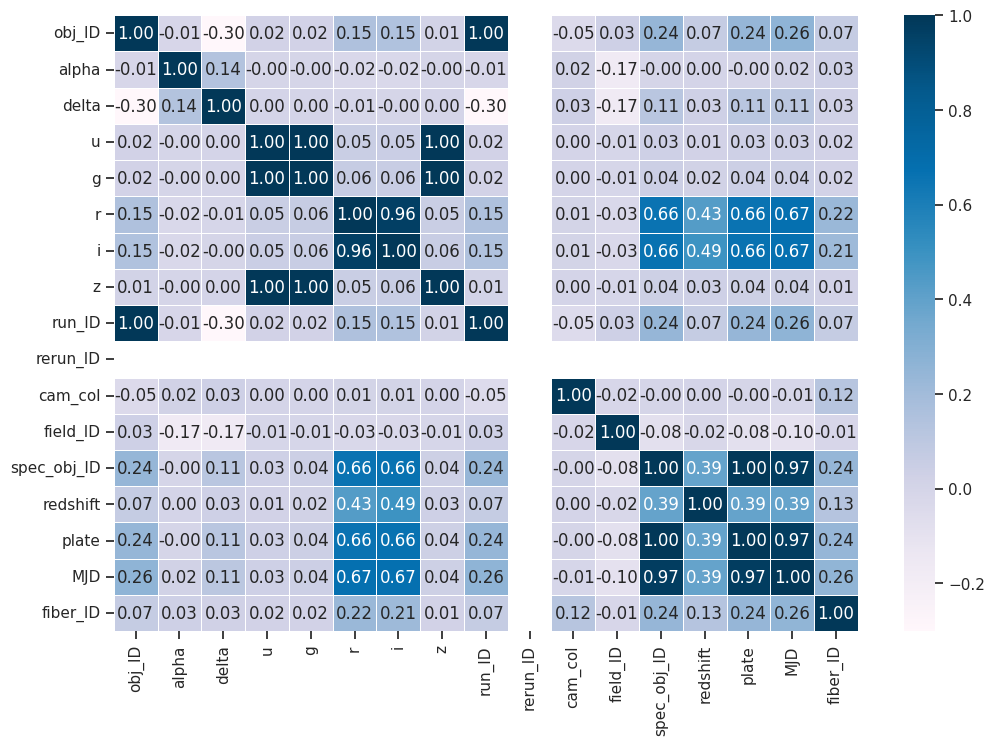

In [75]:
import seaborn as sns
f,ax = plt.subplots(figsize=(12,8))
sns.heatmap(data.corr(), cmap="PuBu", annot=True, linewidths=0.5, fmt= '.2f',ax=ax)
plt.show()

In [76]:
data = data.drop(['obj_ID','run_ID','rerun_ID','cam_col','field_ID','fiber_ID','spec_obj_ID','plate','MJD'], axis = 1)

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   alpha     100000 non-null  float64
 1   delta     100000 non-null  float64
 2   u         100000 non-null  float64
 3   g         100000 non-null  float64
 4   r         100000 non-null  float64
 5   i         100000 non-null  float64
 6   z         100000 non-null  float64
 7   class     100000 non-null  object 
 8   redshift  100000 non-null  float64
dtypes: float64(8), object(1)
memory usage: 6.9+ MB


In [78]:
data

alpha      delta         u         g         r         i  \
0      135.689107  32.494632  23.87882  22.27530  20.39501  19.16573   
1      144.826101  31.274185  24.77759  22.83188  22.58444  21.16812   
2      142.188790  35.582444  25.26307  22.66389  20.60976  19.34857   
3      338.741038  -0.402828  22.13682  23.77656  21.61162  20.50454   
4      345.282593  21.183866  19.43718  17.58028  16.49747  15.97711   
...           ...        ...       ...       ...       ...       ...   
99995   39.620709  -2.594074  22.16759  22.97586  21.90404  21.30548   
99996   29.493819  19.798874  22.69118  22.38628  20.45003  19.75759   
99997  224.587407  15.700707  21.16916  19.26997  18.20428  17.69034   
99998  212.268621  46.660365  25.35039  21.63757  19.91386  19.07254   
99999  196.896053  49.464643  22.62171  21.79745  20.60115  20.00959   

              z   class  redshift  
0      18.79371  GALAXY  0.634794  
1      21.61427  GALAXY  0.779136  
2      18.94827  GALAXY  0.644195  
3      19.25010  GALAXY  0.932346  
4      15.54461  GALAXY  0.116123  
...         ...     ...       ...  
99995  20.73569  GALAXY  0.000000  
99996  19.41526  GALAXY  0.404895  
99997  17.35221  GALAXY  0.143366  
99998  18.62482  GALAXY  0.455040  
99999  19.28075  GALAXY  0.542944  

[100000 rows x 9 columns]

In [79]:
data.describe().T

count        mean        std          min         25%  \
alpha     100000.0  177.629117  96.502241     0.005528  127.518222   
delta     100000.0   24.135305  19.644665   -18.785328    5.146771   
u         100000.0   21.980468  31.769291 -9999.000000   20.352353   
g         100000.0   20.531387  31.750292 -9999.000000   18.965230   
r         100000.0   19.645762   1.854760     9.822070   18.135828   
i         100000.0   19.084854   1.757895     9.469903   17.732285   
z         100000.0   18.668810  31.728152 -9999.000000   17.460677   
redshift  100000.0    0.576661   0.730707    -0.009971    0.054517   

                 50%         75%         max  
alpha     180.900700  233.895005  359.999810  
delta      23.645922   39.901550   83.000519  
u          22.179135   23.687440   32.781390  
g          21.099835   22.123767   31.602240  
r          20.125290   21.044785   29.571860  
i          19.405145   20.396495   32.141470  
z          19.004595   19.921120   29.383740  
redshift    0.424173    0.704154    7.011245

In [80]:
data.isnull().sum()

alpha       0
delta       0
u           0
g           0
r           0
i           0
z           0
class       0
redshift    0
dtype: int64

In [81]:
data["class"].value_counts()

GALAXY    59445
STAR      21594
QSO       18961
Name: class, dtype: int64

<Axes: xlabel='class', ylabel='count'>

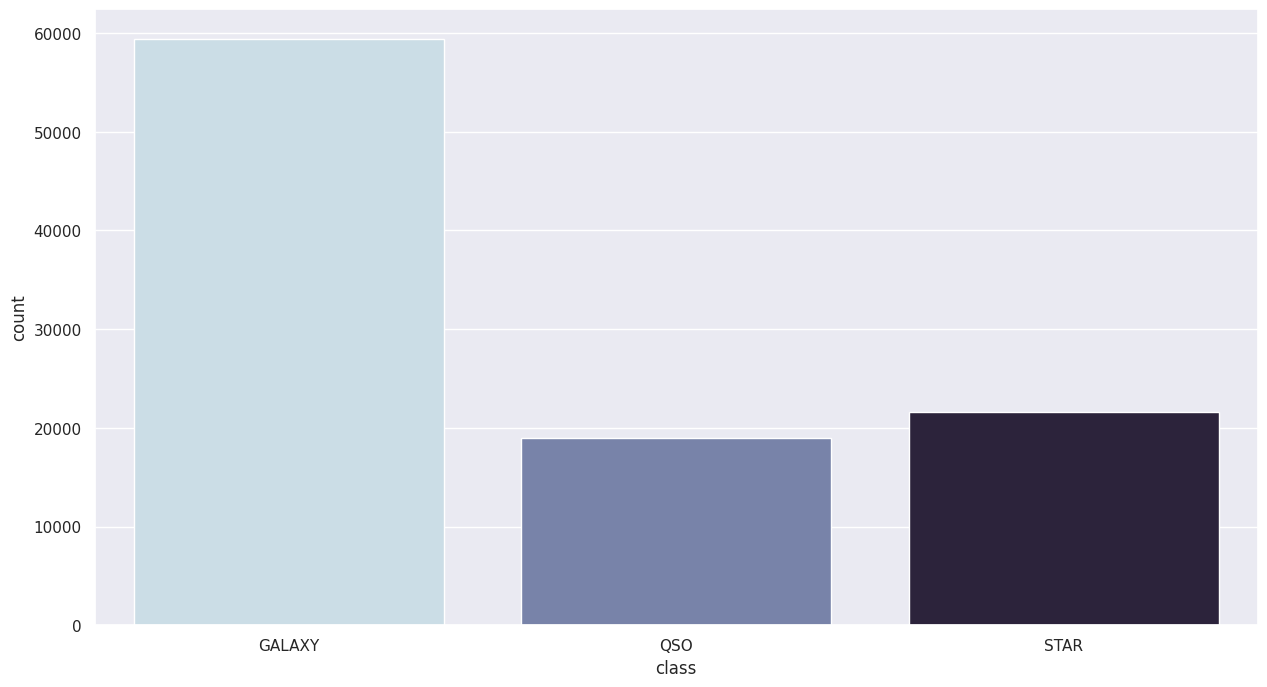

In [82]:
sns.set_style('darkgrid')
plt.figure(figsize=(15,8))
sns.countplot(x = data['class'], palette = 'ch:s=.25,rot=-.25')

# **Data Preprocessing**

alpha          Axes(0.125,0.798085;0.133621x0.0819149)
delta       Axes(0.285345,0.798085;0.133621x0.0819149)
u            Axes(0.44569,0.798085;0.133621x0.0819149)
g           Axes(0.606034,0.798085;0.133621x0.0819149)
r           Axes(0.766379,0.798085;0.133621x0.0819149)
i              Axes(0.125,0.699787;0.133621x0.0819149)
z           Axes(0.285345,0.699787;0.133621x0.0819149)
redshift     Axes(0.44569,0.699787;0.133621x0.0819149)
dtype: object

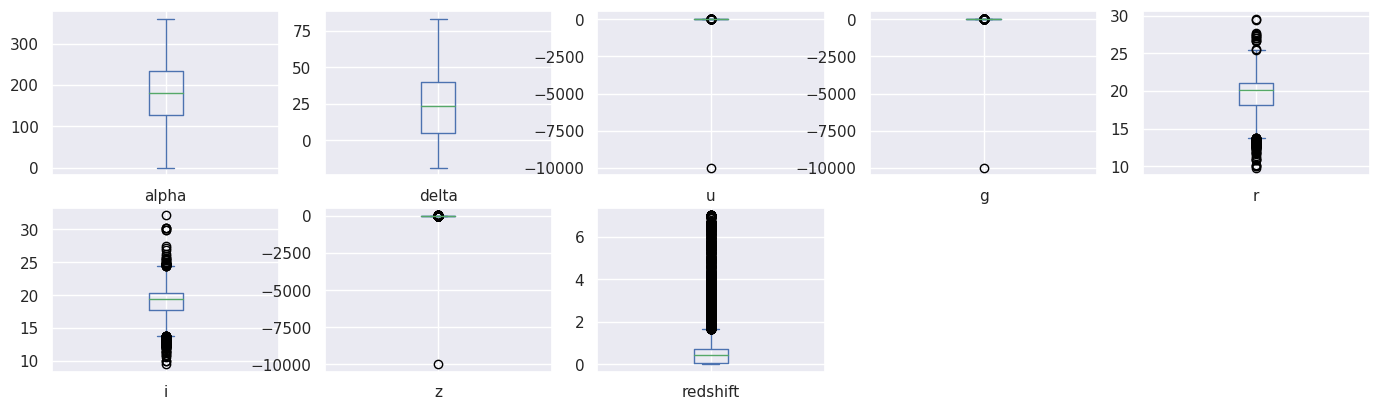

In [83]:
data.plot(kind='box', subplots=True, layout=(8,5), figsize=(17,20))

In [84]:
numerical_columns = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift']

In [85]:
z_scores = np.abs(stats.zscore(data[numerical_columns]))
threshold = 3
outlier_indices = np.where(z_scores > threshold)

In [86]:
data = data.drop(outlier_indices[0])

In [87]:
data.shape

(97884, 9)

alpha          Axes(0.125,0.798085;0.133621x0.0819149)
delta       Axes(0.285345,0.798085;0.133621x0.0819149)
u            Axes(0.44569,0.798085;0.133621x0.0819149)
g           Axes(0.606034,0.798085;0.133621x0.0819149)
r           Axes(0.766379,0.798085;0.133621x0.0819149)
i              Axes(0.125,0.699787;0.133621x0.0819149)
z           Axes(0.285345,0.699787;0.133621x0.0819149)
redshift     Axes(0.44569,0.699787;0.133621x0.0819149)
dtype: object

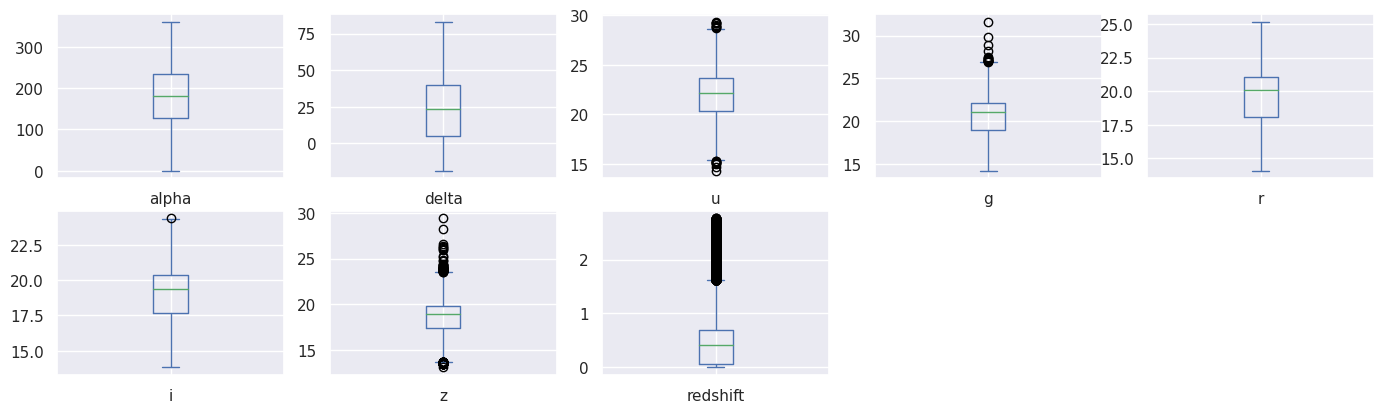

In [88]:
data.plot(kind='box', subplots=True, layout=(8,5), figsize=(17,20))

# **Univariate Analysis**

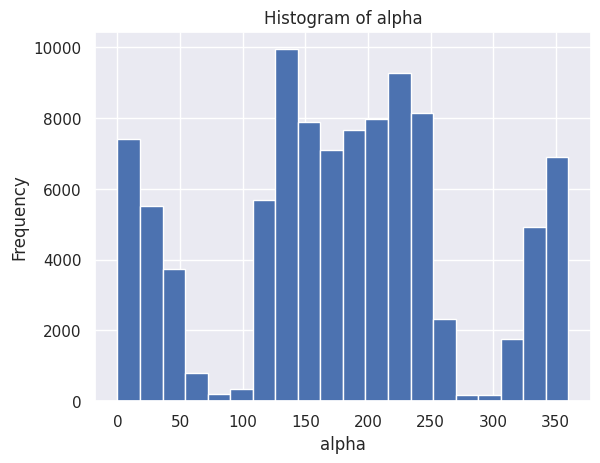

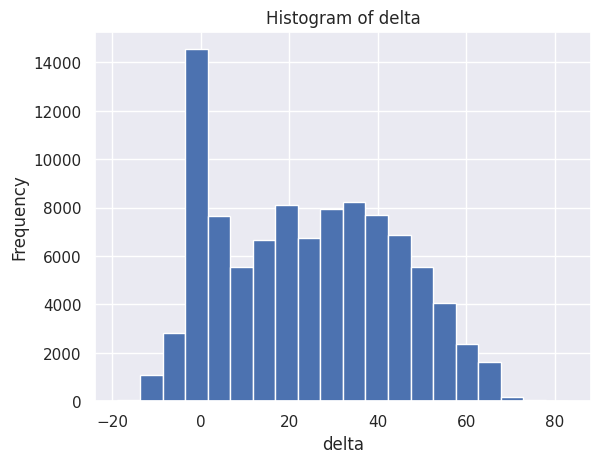

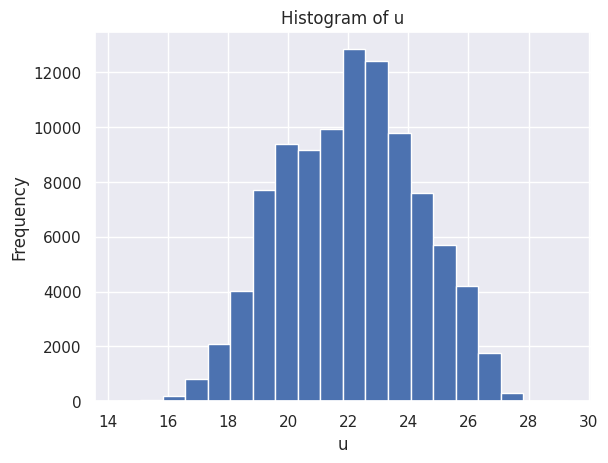

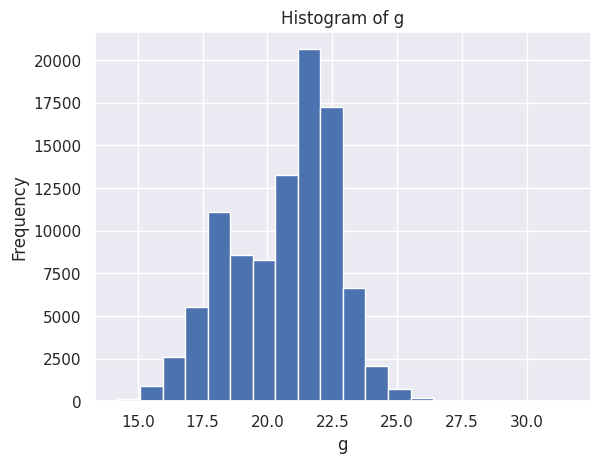

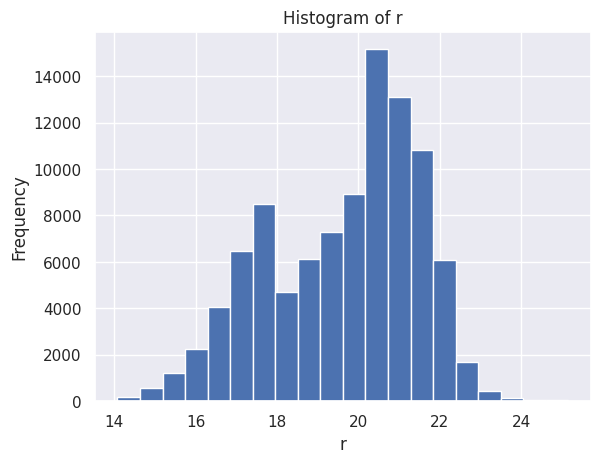

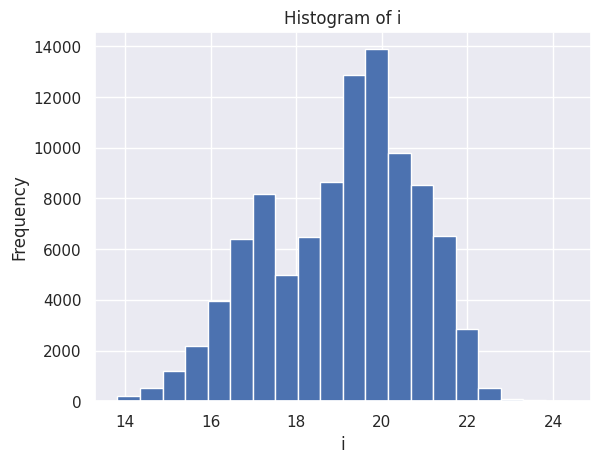

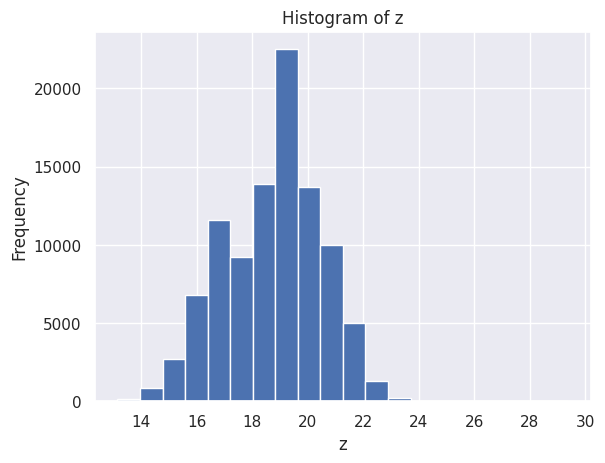

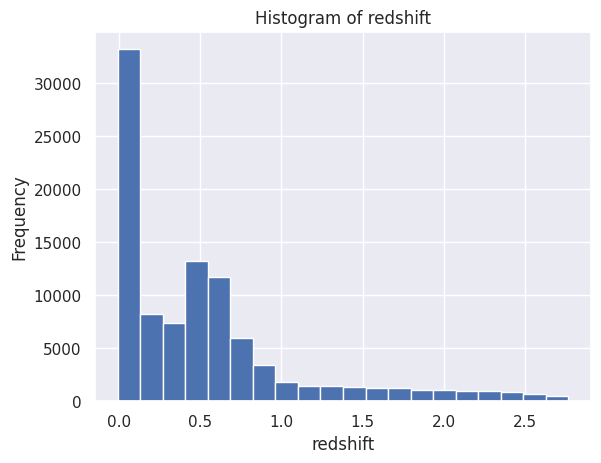

In [89]:
for column in numerical_columns:
    # Calculate summary statistics
    column_data = data[column]
    min_val = column_data.min()
    max_val = column_data.max()
    mean_val = column_data.mean()
    median_val = column_data.median()
    std_val = column_data.std()
    plt.figure()
    plt.hist(column_data, bins=20)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# **Bivariate Analysis**

In [90]:
galaxy = data[data['class']=='GALAXY']
star = data[data['class']=='STAR']
qso = data[data['class']=='QSO']

Text(0.5, 1.0, 'Alpha Vs Redshift for Galaxy')

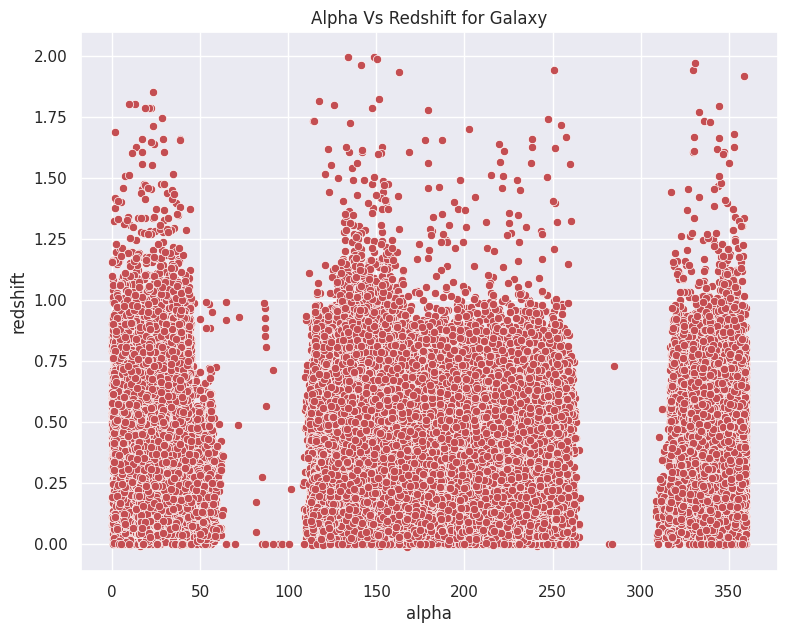

In [91]:
plt.figure(figsize=(9,7))
sns.scatterplot(x='alpha',y='redshift',data=galaxy,color='r')
plt.title("Alpha Vs Redshift for Galaxy")

Text(0.5, 1.0, 'Alpha Vs Redshift for Star')

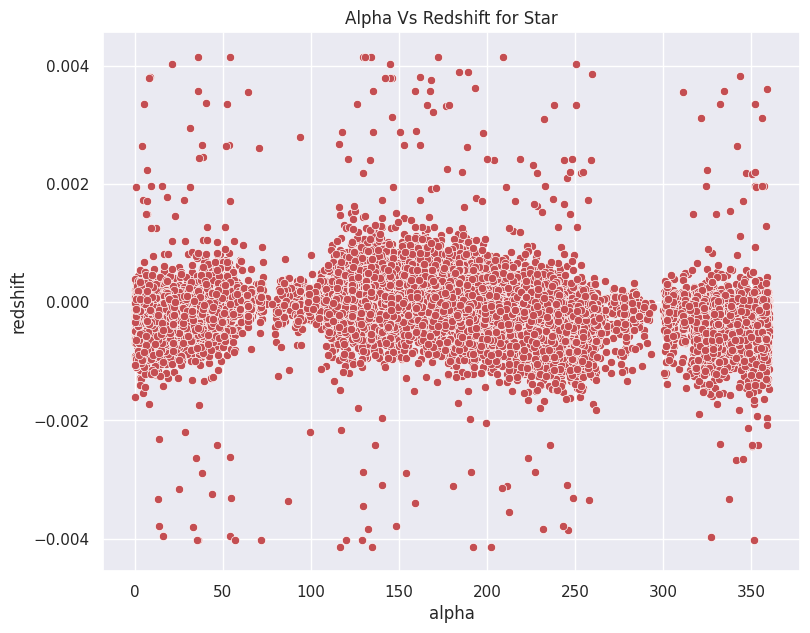

In [92]:
plt.figure(figsize=(9,7))
sns.scatterplot(x='alpha',y='redshift',data=star,color='r')
plt.title("Alpha Vs Redshift for Star")

Text(0.5, 1.0, 'Alpha Vs Redshift for QSO')

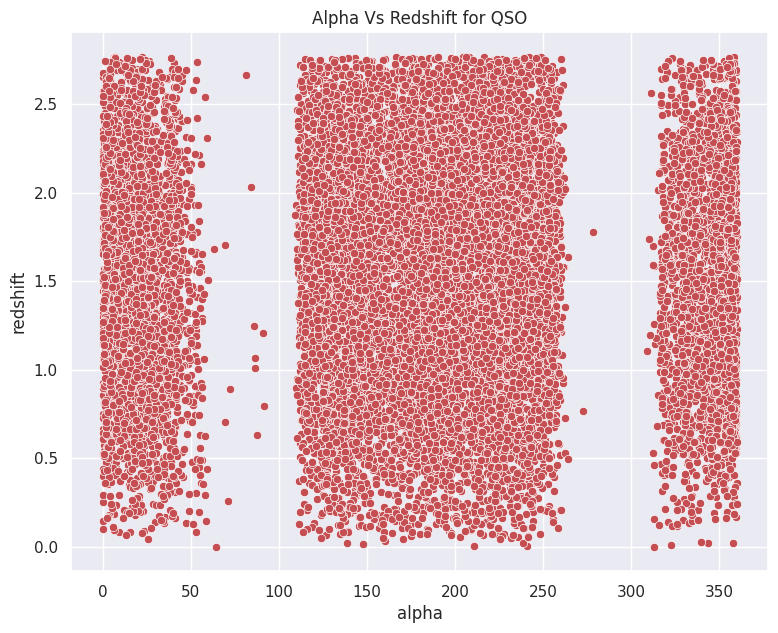

In [93]:
plt.figure(figsize=(9,7))
sns.scatterplot(x='alpha',y='redshift',data=qso,color='r')
plt.title("Alpha Vs Redshift for QSO")

# **Multivariate Analysis**

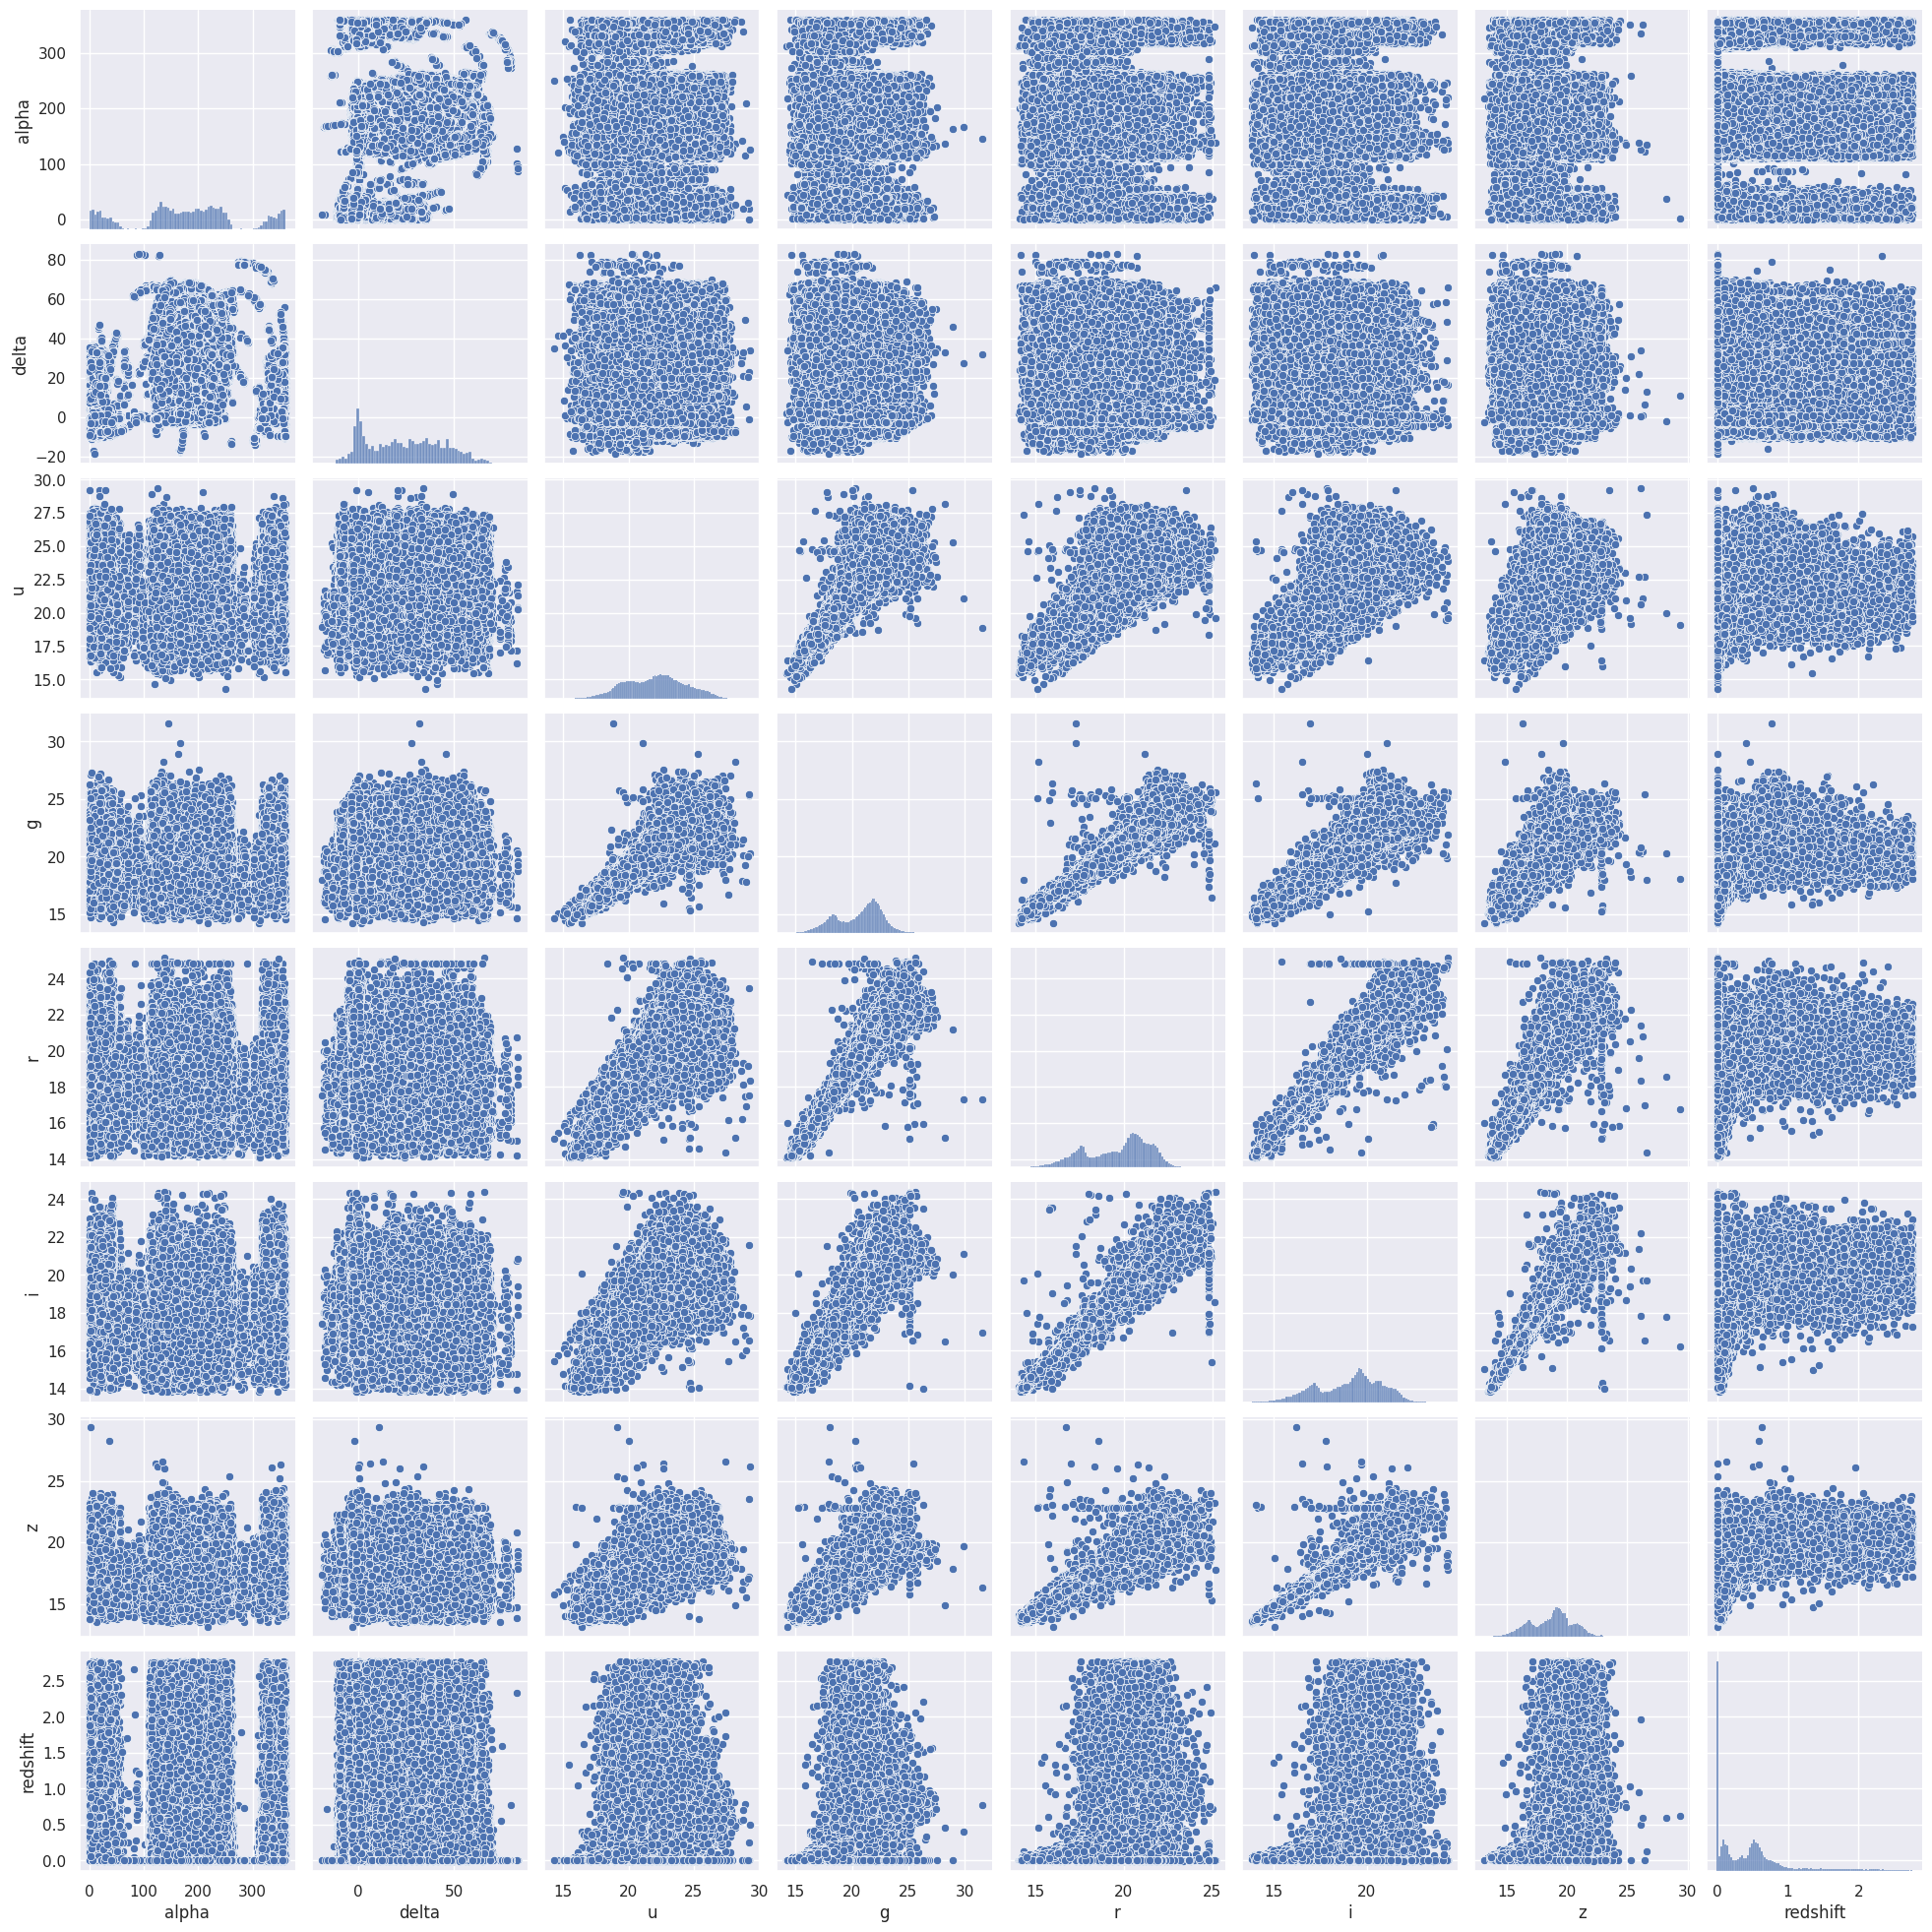

In [94]:
sns.pairplot(data[numerical_columns])
plt.show()

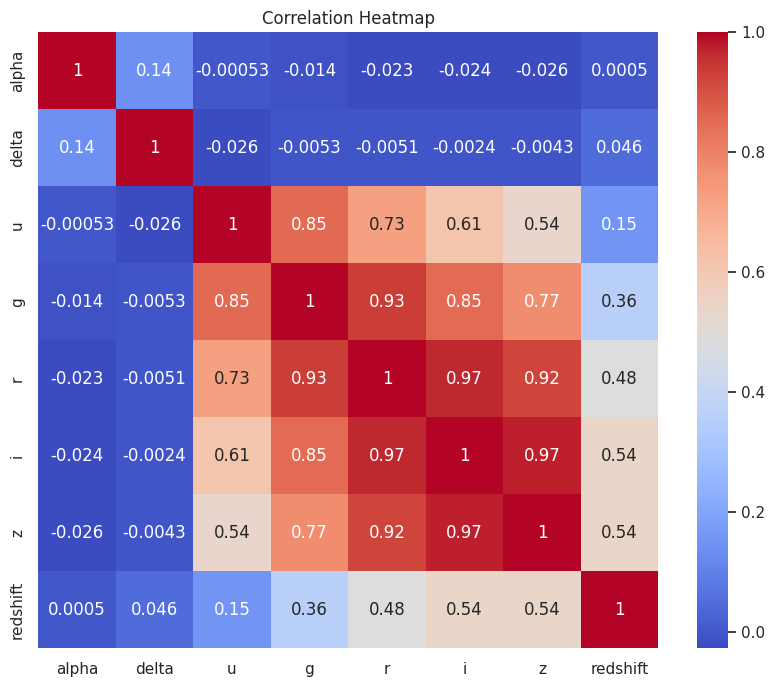

In [95]:
correlation_matrix = data[numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# **Splitting the Data**



In [96]:
inputs = data.drop('class',axis=1)
target = data['class']

In [97]:
encoder = LabelEncoder()
target = encoder.fit_transform(target)

In [98]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(inputs,target,test_size=0.2)

# **Data Scaling**

In [99]:
scalar = StandardScaler()
x_train = scalar.fit_transform(x_train)
x_test  = scalar.transform(x_test)

# **Modelling**

In [100]:
models = {
    KNeighborsClassifier(n_neighbors=3):'K-Neighbors Classifier',
    SVC():"Support Vector Machine",
    RandomForestClassifier():'Random Forest Classifier',
    LogisticRegression(max_iter=1000):'Logistic Regression',
    DecisionTreeClassifier():'Decision Tree Classifier'
}

In [101]:
for m in models.keys():
    m.fit(x_train,y_train)
for model,name in models.items():
     print(f"Accuracy Score for {name} is : ",(model.score(x_test,y_test))*100,"%")

Accuracy Score for K-Neighbors Classifier is :  94.17684016958677 %
Accuracy Score for Support Vector Machine is :  96.46523982224039 %
Accuracy Score for Random Forest Classifier is :  97.81886908106452 %
Accuracy Score for Logistic Regression is :  95.71946672115237 %
Accuracy Score for Decision Tree Classifier is :  96.51632017162997 %


# **Model Evaluation**

In [102]:
for model,name in models.items():
    y_pred = model.predict(x_test)
    print(f"Classification Report for : {name}")
    print(classification_report(y_test,y_pred))

Classification Report for : K-Neighbors Classifier
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     11827
           1       0.95      0.91      0.93      3397
           2       0.92      0.92      0.92      4353

    accuracy                           0.94     19577
   macro avg       0.94      0.93      0.93     19577
weighted avg       0.94      0.94      0.94     19577

Classification Report for : Support Vector Machine
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     11827
           1       0.97      0.90      0.93      3397
           2       0.95      1.00      0.97      4353

    accuracy                           0.96     19577
   macro avg       0.96      0.96      0.96     19577
weighted avg       0.96      0.96      0.96     19577

Classification Report for : Random Forest Classifier
              precision    recall  f1-score   support

           0       0.98     

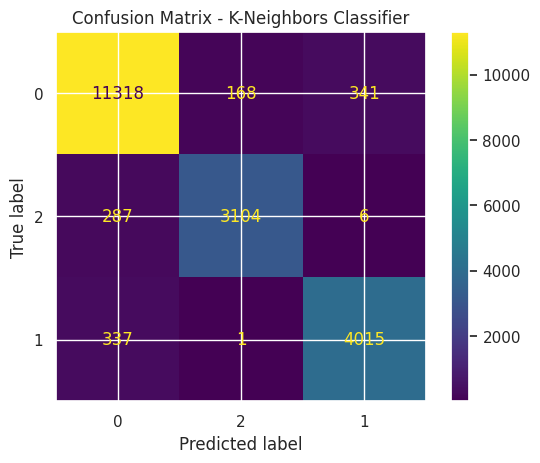

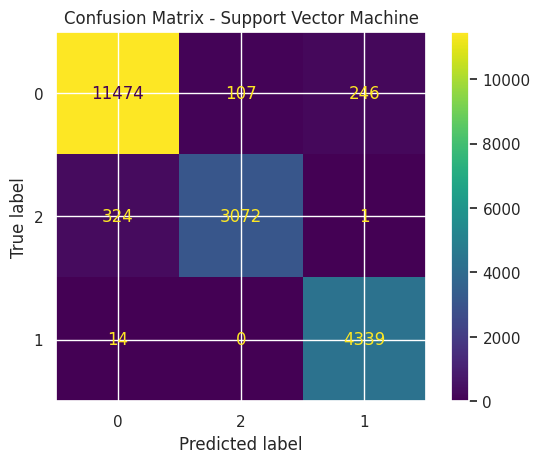

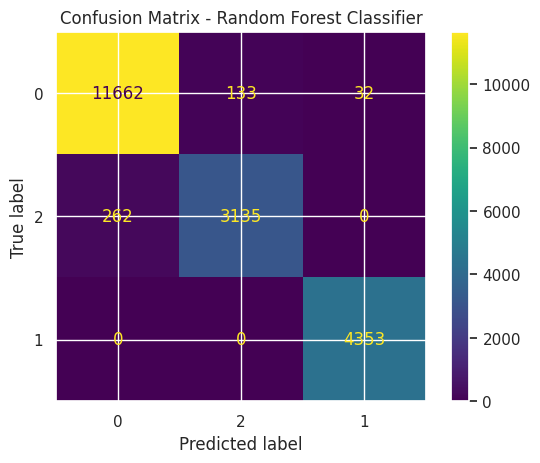

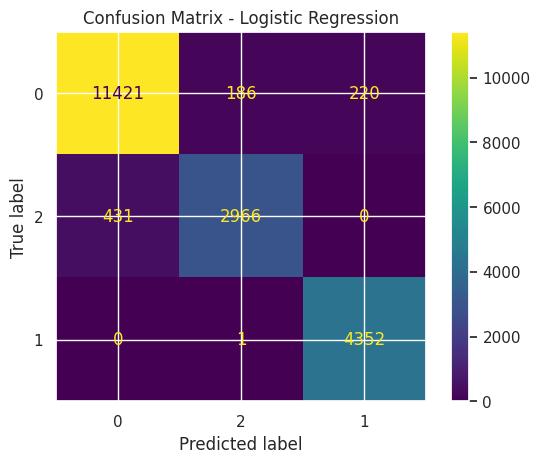

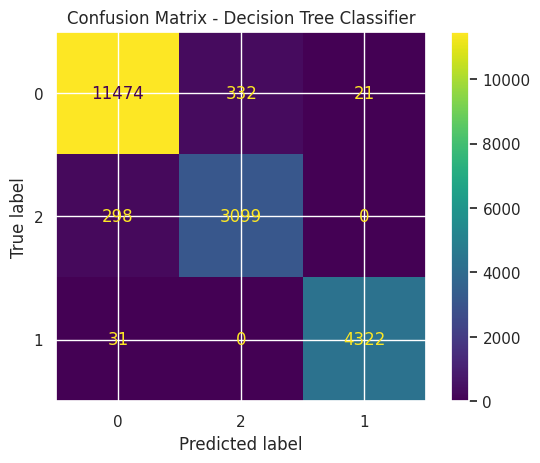

In [115]:
for model,name in models.items():
    y_pred = model.predict(x_test)
    labels = pd.unique(y_test)
    cm = metrics.confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=labels)
    cm_display.plot()
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# **Knowledge Graph**

In [ ]:
knowledge_graph = nx.DiGraph()

classes = data['class'].unique()
knowledge_graph.add_nodes_from(classes)

for _, row in data.iterrows():
    features = row[['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift']]
    obj_class = row['class']

    for feature in features:
        knowledge_graph.add_edge(feature, obj_class)

pos = nx.spring_layout(knowledge_graph)
nx.draw_networkx(knowledge_graph, pos=pos, with_labels=True)
plt.title("Knowledge Graph")
plt.show()